In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [7]:
# BAGIAN 1: DATA LOADING DAN DATA SPLITTING

df = pd.read_csv('./bank-additional-full.csv', sep= ';')

# Ganti nama kolom dan encoding target di awal
df.rename(columns = {'y':'deposit'}, inplace = True)

# Pisahkan Fitur (X) dan Target (y)
X = df.drop('deposit', axis=1)
y = df['deposit'].map({'yes': 1, 'no': 0}) # Target Encoding

# Split data ke Train dan Test (Stratify untuk data tidak seimbang)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
class CustomImputer(BaseEstimator, TransformerMixin):
    """Transformer kustom untuk menerapkan logika imputation rule-based."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        # Logika Imputasi untuk 'unknown' (Job & Education)
        X_copy.loc[(X_copy['age']>60) & (X_copy['job']=='unknown'), 'job'] = 'retired'
        X_copy.loc[(X_copy['education']=='unknown') & (X_copy['job']=='management'), 'education'] = 'university.degree'
        X_copy.loc[(X_copy['education']=='unknown') & (X_copy['job']=='services'), 'education'] = 'high.school'
        X_copy.loc[(X_copy['education']=='unknown') & (X_copy['job']=='housemaid'), 'education'] = 'basic.4y'
        X_copy.loc[(X_copy['job'] == 'unknown') & (X_copy['education']=='basic.4y'), 'job'] = 'blue-collar'
        X_copy.loc[(X_copy['job'] == 'unknown') & (X_copy['education']=='basic.6y'), 'job'] = 'blue-collar'
        X_copy.loc[(X_copy['job'] == 'unknown') & (X_copy['education']=='basic.9y'), 'job'] = 'blue-collar'
        X_copy.loc[(X_copy['job']=='unknown') & (X_copy['education']=='professional.course'), 'job'] = 'technician'

        return X_copy

class CyclicalFeatureTransformer(BaseEstimator, TransformerMixin):
    """Mengubah fitur siklus (month, day_of_week) menjadi sin dan cos."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        # Transformasi Bulan
        month_map = {'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
        X_copy['month_num'] = X_copy['month'].map(month_map)
        X_copy['month_sin'] = np.sin(2 * np.pi * X_copy['month_num']/12)
        X_copy['month_cos'] = np.cos(2 * np.pi * X_copy['month_num']/12)
        X_copy.drop(columns=['month', 'month_num'], inplace=True)

        # Transformasi Hari
        day_map = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5}
        X_copy['day_num'] = X_copy['day_of_week'].map(day_map)
        X_copy['day_sin'] = np.sin(2 * np.pi * X_copy['day_num']/5)
        X_copy['day_cos'] = np.cos(2 * np.pi * X_copy['day_num']/5)
        X_copy.drop(columns=['day_of_week', 'day_num'], inplace=True)

        return X_copy

    # Tambahkan metode get_feature_names_out
    def get_feature_names_out(self, input_features=None):
        return ['month_sin', 'month_cos', 'day_sin', 'day_cos']

In [9]:
# BAGIAN 3: PIPELINE PREPROCESSING

# 1. Definisikan kategori untuk Ordinal/Binary Encoding (sesuai urutan Anda)
housing_loan_map = ['unknown','no', 'yes']
default_map = ['unknown', 'no', 'yes'] # Termasuk 'unknown'
education_order = [
    'illiterate', 'basic.4y', 'basic.6y', 'basic.9y',
    'high.school', 'professional.course', 'university.degree', 'unknown'
]
poutcome_order = ['nonexistent', 'failure', 'success']

# 2. Definisikan Kolom
cyclical_features = ['month', 'day_of_week']
ordinal_features = ['education', 'poutcome']
binary_features = ['default', 'housing', 'loan']
onehot_features = ['job', 'marital', 'contact']
# Kolom Numerik yang tersisa, termasuk 'duration' (meskipun ada risiko data leakage)
numerical_features = ['age', 'duration', 'campaign', 'pdays', 'previous',
                      'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

# 3. Buat Transformer

# Transformer untuk Ordinal/Binary (OrdinalEncoder)
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(
        categories=[education_order, poutcome_order, default_map, housing_loan_map, housing_loan_map],
        handle_unknown='use_encoded_value', unknown_value=-1 # Menangani nilai yang tidak terduga
    )),
    ('scaler', StandardScaler())
])

# Transformer untuk One-Hot (OneHotEncoder)
onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Transformer untuk Numerik
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 4. Gabung Semua Preprocessing dengan ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        # Urutan penting: Cyclical & Numerik menggunakan kolom asli sebelum diproses
        ('cyclic', CyclicalFeatureTransformer(), cyclical_features),
        ('ordinal_bin', ordinal_transformer, ordinal_features + binary_features),
        ('onehot', onehot_transformer, onehot_features),
        ('num_only', numerical_transformer, numerical_features)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)
preprocessor_full = Pipeline(steps=[
    ('impute_custom', CustomImputer()), # Imputasi kustom
    ('preprocessing', preprocessor)      # Lalu semua encoding dan scaling
])



--- ANALISIS KETIDAKSEIMBANGAN TARGET (y_train) ---
Jumlah 'No Deposit' (0): 29238 (88.73%)
Jumlah 'Deposit'    (1): 3712 (11.27%)


C:\Users\hahaha\AppData\Local\Temp\ipykernel_5688\3153505584.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_counts.index, y=target_counts.values, palette=['red', 'green'])


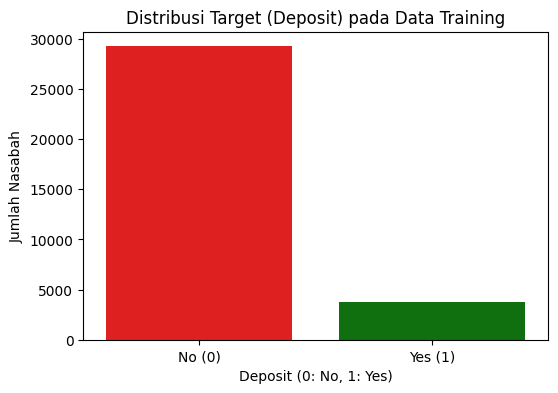


--- MENAMPILKAN DATA FITUR (X) SETELAH PREPROCESSING ---
Shape Data Awal: (32950, 20)
Shape Data Setelah Preprocessing: (32950, 37)

5 Baris Pertama Data Terproses (Standardized & Encoded):


,month_sin,month_cos,day_sin,day_cos,education,poutcome,default,housing,loan,job_admin.,...,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
25611,-5.000000e-01,0.866025,-0.587785,-0.809017,-0.745281,-0.374417,-1.935404,-0.914500,-0.320569,0.0,...,0.863739,-0.120196,0.522981,0.196584,-0.350127,-0.114858,-0.648967,-0.322269,0.288964,0.398990
26010,-5.000000e-01,0.866025,-0.587785,-0.809017,1.027703,1.813389,0.516123,-0.914500,-0.320569,0.0,...,-0.289722,-0.216732,-0.203688,0.196584,1.653813,-0.114858,-0.648967,-0.322269,0.288964,0.398990
40194,-5.000000e-01,-0.866025,0.951057,0.309017,-1.927270,-0.374417,0.516123,-0.914500,-0.320569,0.0,...,3.651268,3.436173,-0.567023,0.196584,-0.350127,-1.133161,1.103451,0.045048,-1.583296,-2.420139
297,5.000000e-01,-0.866025,0.951057,0.309017,1.027703,-0.374417,0.516123,0.916389,-0.320569,1.0,...,-0.385843,-0.533368,-0.203688,0.196584,-0.350127,0.648868,0.721890,0.887717,0.713535,0.332723
36344,1.224647e-16,-1.000000,0.587785,-0.809017,1.027703,-0.374417,0.516123,-0.914500,-0.320569,0.0,...,1.824956,0.424264,-0.203688,0.196584,-0.350127,-1.896888,-1.058152,-0.062987,-1.357472,-1.252175


,count,mean,std,min,25%,50%,75%,max
month_sin,32950.0,-6.145031e-02,0.590798,-1.000000,-0.500000,1.224647e-16,0.500000,1.000000
month_cos,32950.0,-5.773982e-01,0.560191,-1.000000,-0.866025,-8.660254e-01,-0.500000,1.000000
day_sin,32950.0,-2.565411e-03,0.714923,-0.951057,-0.587785,-2.449294e-16,0.587785,0.951057
day_cos,32950.0,1.878667e-03,0.699217,-0.809017,-0.809017,3.090170e-01,0.309017,1.000000
education,32950.0,-1.181722e-16,1.000015,-2.518265,-0.745281,-1.542864e-01,1.027703,1.618698
poutcome,32950.0,4.205033e-18,1.000015,-0.374417,-0.374417,-3.744169e-01,-0.374417,4.001195
default,32950.0,7.159338e-17,1.000015,-1.935404,0.516123,5.161226e-01,0.516123,2.967649
housing,32950.0,1.707890e-16,1.000015,-2.745390,-0.914500,9.163895e-01,0.916389,0.916389
loan,32950.0,1.017834e-16,1.000015,-2.819447,-0.320569,-3.205692e-01,-0.320569,2.178308
job_admin.,32950.0,2.523217e-01,0.434351,0.000000,0.000000,0.000000e+00,1.000000,1.000000


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

print("--- ANALISIS KETIDAKSEIMBANGAN TARGET (y_train) ---")
target_counts = pd.Series(y_train).value_counts()
target_pct = pd.Series(y_train).value_counts(normalize=True) * 100

print(f"Jumlah 'No Deposit' (0): {target_counts[0]} ({target_pct[0]:.2f}%)")
print(f"Jumlah 'Deposit'    (1): {target_counts[1]} ({target_pct[1]:.2f}%)")

# Visualisasi
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette=['red', 'green'])
plt.title("Distribusi Target (Deposit) pada Data Training")
plt.xlabel("Deposit (0: No, 1: Yes)")
plt.ylabel("Jumlah Nasabah")
plt.xticks(ticks=[0, 1], labels=['No (0)', 'Yes (1)'])
plt.show()

# ======================================================================
# 2. MELIHAT DATA FITUR SETELAH PREPROCESSING (X_train)
# ======================================================================

print("\n--- MENAMPILKAN DATA FITUR (X) SETELAH PREPROCESSING ---")

# a. Fit Pipeline Preprocessing pada X_train
X_train_processed_array = preprocessor_full.fit_transform(X_train, y_train)

# b. Mendapatkan Nama Fitur Baru
# Ini agak tricky karena ColumnTransformer membungkus fitur
# Kita ambil langkah 'preprocessing' dari dalam pipeline utama
col_transformer = preprocessor_full.named_steps['preprocessing']
feature_names = col_transformer.get_feature_names_out()

# c. Membuat DataFrame untuk dilihat
X_train_processed_df = pd.DataFrame(
    X_train_processed_array,
    columns=feature_names,
    index=X_train.index
)

print(f"Shape Data Awal: {X_train.shape}")
print(f"Shape Data Setelah Preprocessing: {X_train_processed_df.shape}")
print("\n5 Baris Pertama Data Terproses (Standardized & Encoded):")
display(X_train_processed_df.head())

display(X_train_processed_df.describe().T.head(10))

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# BAGIAN 4: DEFINISI DAN PELATIHAN MODEL

models_to_test = {}

# Model 1: Logistic Regression
full_pipeline_lr = Pipeline(steps=[
    ('preprocessor_final', preprocessor_full),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear', C=1.0, class_weight='balanced'))
])
print("Memulai Pelatihan Model Regresi Logistik...")
full_pipeline_lr.fit(X_train, y_train)
models_to_test["Logistic Regression"] = full_pipeline_lr
print("Pelatihan LR Selesai.")


# Model 2: Naive Bayes (Gaussian)
# Menggunakan GaussianNB karena data numerik telah dinormalisasi (StandardScaler)
full_pipeline_nb = Pipeline(steps=[
    ('preprocessor_final', preprocessor_full),
    ('classifier', GaussianNB())
])
print("\nMemulai Pelatihan Model Naive Bayes...")
full_pipeline_nb.fit(X_train, y_train)
models_to_test["Naive Bayes"] = full_pipeline_nb
print("Pelatihan Naive Bayes Selesai.")


# Model 3: Random Forest Classifier
full_pipeline_rf = Pipeline(steps=[
    ('preprocessor_final', preprocessor_full),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=200, class_weight='balanced'))
])
print("\nMemulai Pelatihan Model Random Forest...")
full_pipeline_rf.fit(X_train, y_train)
models_to_test["Random Forest"] = full_pipeline_rf
print("Pelatihan RF Selesai.")


# BAGIAN 5: EVALUASI PERBANDINGAN MODEL


print("HASIL PERBANDINGAN MODEL PADA DATA TEST")


for name, model in models_to_test.items():
    print(f"\n--- Model: {name} ---")

    # Prediksi Label (0 atau 1)
    y_pred = model.predict(X_test)

    # Prediksi Probabilitas (Score Lead)
    y_proba = model.predict_proba(X_test)[:, 1]

    # 1. Classification Report (F1-Score, Precision, Recall)
    print("\nClassification Report (Threshold Default 0.5):")
    print(classification_report(y_test, y_pred, target_names=['No Deposit (0)', 'Deposit (1)']))

    # 2. AUC Score
    auc = roc_auc_score(y_test, y_proba)
    print(f"Area Under the ROC Curve (AUC): {auc:.4f}")

    # 3. Contoh Score
    print(f"Contoh 5 Probabilitas (Score) Nasabah: {y_proba[:5]}")

Memulai Pelatihan Model Regresi Logistik...
Pelatihan LR Selesai.

Memulai Pelatihan Model Naive Bayes...
Pelatihan Naive Bayes Selesai.

Memulai Pelatihan Model Random Forest...
Pelatihan RF Selesai.
HASIL PERBANDINGAN MODEL PADA DATA TEST

--- Model: Logistic Regression ---

Classification Report (Threshold Default 0.5):
                precision    recall  f1-score   support

No Deposit (0)       0.98      0.85      0.91      7310
   Deposit (1)       0.44      0.89      0.59       928

      accuracy                           0.86      8238
     macro avg       0.71      0.87      0.75      8238
  weighted avg       0.92      0.86      0.88      8238

Area Under the ROC Curve (AUC): 0.9378
Contoh 5 Probabilitas (Score) Nasabah: [0.04819428 0.64846805 0.76498473 0.01189428 0.29287851]

--- Model: Naive Bayes ---

Classification Report (Threshold Default 0.5):
                precision    recall  f1-score   support

No Deposit (0)       0.94      0.88      0.91      7310
   Deposit (

In [12]:
import joblib

# Ambil pipeline Random Forest dari dictionary models_to_test (fallback ke full_pipeline_rf)
rf_pipeline = models_to_test.get("Random Forest", None)
if rf_pipeline is None:
    try:
        rf_pipeline = full_pipeline_rf
    except NameError:
        raise RuntimeError("Random Forest pipeline tidak ditemukan. Pastikan model sudah dilatih dan tersedia sebagai models_to_test['Random Forest'] atau full_pipeline_rf")

# Simpan ke file
filename = "random_forest_pipeline.joblib"
joblib.dump(rf_pipeline, filename)
print(f"Random Forest pipeline disimpan ke: {filename}")

Random Forest pipeline disimpan ke: random_forest_pipeline.joblib
